# Neural Network from Scratch

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Train and Test Network using MNIST 784 Dataset

In [52]:
from sklearn.datasets import fetch_openml
import pandas as pd

mnist_train = pd.read_csv('/content/sample_data/mnist_train_small.csv')

# Assuming '6' is the target column (label)
labels_train = mnist_train['6']
data_train = mnist_train.drop('6', axis=1)
# Rename the labels column for clarity
labels_train = labels_train.rename('label')

mnist_test = pd.read_csv('/content/sample_data/mnist_test.csv')

labels_test = mnist_test['7']
data_test = mnist_test.drop('7', axis=1)
labels_test = labels_test.rename('label')

print("Training data shape:", data_train.shape)
print("Training labels shape:", labels_train.shape)
print("Test data shape:", data_test.shape)
print("Test labels shape:", labels_test.shape)

Training data shape: (19999, 784)
Training labels shape: (19999,)
Test data shape: (9999, 784)
Test labels shape: (9999,)


## Exploring the dataset

8818
(784,)
Image Label: 6


/tmp/ipython-input-3551344330.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  side_length = int(np.sqrt(test_img.shape))


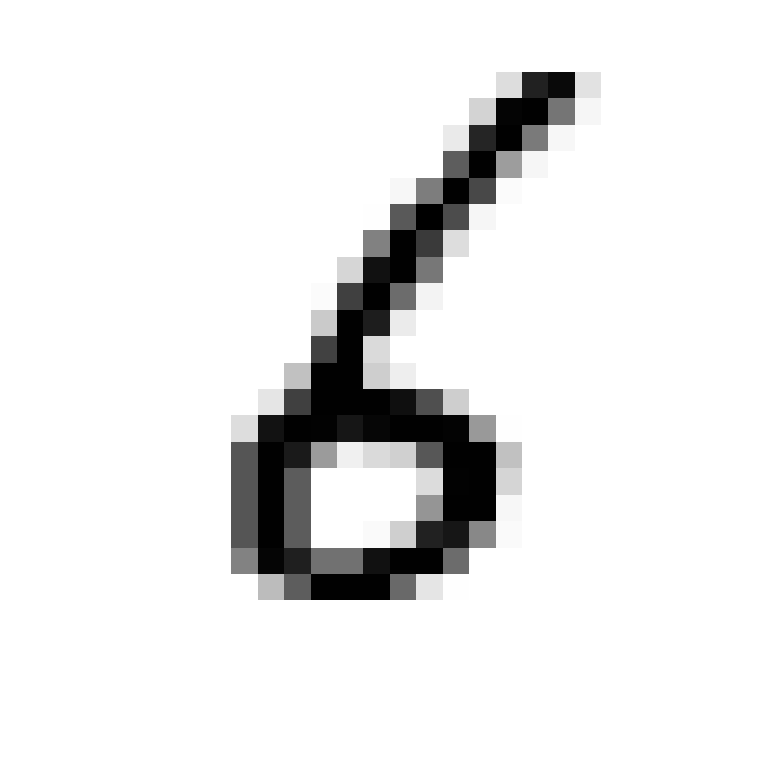

In [54]:
n = np.random.choice(np.arange(data.shape[0]))
print(n)

test_img = data.iloc[n].values
test_label = labels.iloc[n]

print(test_img.shape)

side_length = int(np.sqrt(test_img.shape))
reshaped_test_img = test_img.reshape(side_length, side_length)

print("Image Label: " + str(test_label))

plt.imshow(reshaped_test_img, cmap="Greys")
plt.axis("off")
plt.show()

## Single Deep Layer with 4 Neurons

In [55]:
w1 = np.ones((784, 4)) * 0.01
z1 = np.dot(data, w1)
print(z1.shape)

w2 = np.ones((4, 10))
z2 = np.dot(z1, w2)
print(z2.shape)

(19999, 4)
(19999, 10)


## Activation Functions

In [56]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))
def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0, z)
def tanh(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)
def leaky_relu(z: np.ndarray) -> np.ndarray:
    return np.where(z > 0, z, z * 0.01)

## For the output layer, we are going to use Softmax

In [57]:
def softmax(z: np.ndarray) -> np.ndarray:
  e = np.exp(z - np.max(z))
  return e / np.sum(e, axis=0)

## Preprocessing Functions <br>
1. Normalize function to scale inputs to the range [0,1]
2. One-Hot-Encode Function that will turn array of labels form an n-sized vector to an n x m array

In [58]:
def normalize(x: np.ndarray) -> np.ndarray:
    return (x - np.min(x)) / (np.max(x) - np.min(x))

## Create an identity matrix to perform One-Hot-Encoding.

In [59]:
def one_hot_encode(x: np.ndarray, num_labels: int) -> np.ndarray:
  return np.eye(num_labels)[x]

## Derivatives in performing Gradient Descent

In [60]:
def derivative(function_name: str, z: np.ndarray) -> np.ndarray:
    if function_name == "sigmoid":
        return sigmoid(z) * (1 - sigmoid(z))
    if function_name == "tanh":
        return 1 - np.square(tanh(z))
    if function_name == "relu":
        y = (z > 0) * 1
        return y
    if function_name == "leaky_relu":
        return  np.where(z > 0, 1, 0.01)
    return "Not an activation"

## The Neural Network

In [61]:
from typing import List

def __init__(self, X: np.ndarray, y: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, activation: str, num_labels: int, architecture: List[int]):
        self.X = normalize(X) # normalize the training data in range 0,1
        assert np.all((self.X >= 0) | (self.X <= 1)) # test that normalize succeded
        self.X, self.X_test = X.copy(), X_test.copy()
        self.y, self.y_test = y.copy(), y_test.copy()
        self.layers = {} # define the dictionary to store results of the activation
        self.architecture = architecture # Hidden layers size as an array
        self.activation = activation # activation function
        assert self.activation in ["relu", "tanh", "sigmoid", "leaky_relu"]
        self.parameters = {}
        self.num_labels = num_labels
        self.m = X.shape[1]
        self.architecture.append(self.num_labels)
        self.num_input_features = X.shape[0]
        self.architecture.insert(0, self.num_input_features)
        self.L = len(architecture)
        assert self.X.shape == (self.num_input_features, self.m)
        assert self.y.shape == (self.num_labels, self.m)

## Initializing Parameters

In [62]:
def initialize_parameters(self):
        for i in range(1, self.L):
            print(f"Initializing parameters for layer: {i}.")
            self.parameters["w"+str(i)] = np.random.randn(self.architecture[i], self.architecture[i-1]) * 0.01
            self.parameters["b"+str(i)] = np.zeros((self.architecture[i], 1))

## Feedforward
1. Iterate over the range
2. For each iteration in the range, we calculate the product of the parameteras given; parameters[wi] and layers[a-i].
3. Apply the activation fucntion of choice to layers[zi] to obtain the output, and then store the values of layers.

In [63]:
def forward(self):
        params=self.parameters
        self.layers["a0"] = self.X
        for l in range(1, self.L-1):
            self.layers["z" + str(l)] = np.dot(params["w" + str(l)],
                                               self.layers["a"+str(l-1)]) + params["b"+str(l)]
            self.layers["a" + str(l)] = eval(self.activation)(self.layers["z"+str(l)])
            assert self.layers["a"+str(l)].shape == (self.architecture[l], self.m)
        self.layers["z" + str(self.L-1)] = np.dot(params["w" + str(self.L-1)],
                                                  self.layers["a"+str(self.L-2)]) + params["b"+str(self.L-1)]
        self.layers["a"+str(self.L-1)] = softmax(self.layers["z"+str(self.L-1)])
        self.output = self.layers["a"+str(self.L-1)]
        assert self.output.shape == (self.num_labels, self.m)
        assert all([s for s in np.sum(self.output, axis=1)])

        cost = - np.sum(self.y * np.log(self.output + 0.000000001))

        return cost, self.layers

## Backpropagation <br>
1. Gradients for weights = dot product of dz and the transpose of the previous activation, averaged over examples.
2. Gradients for biases = averaged dz (use keepdims=True to avoid shape issues).
3. Store the gradient of the previous activation in dAPrev.

In [64]:
def backpropagate(self):
        derivatives = {}
        dZ = self.output - self.y
        assert dZ.shape == (self.num_labels, self.m)
        dW = np.dot(dZ, self.layers["a" + str(self.L-2)].T) / self.m
        db = np.sum(dZ, axis=1, keepdims=True) / self.m
        dAPrev = np.dot(self.parameters["w" + str(self.L-1)].T, dZ)
        derivatives["dW" + str(self.L-1)] = dW
        derivatives["db" + str(self.L-1)] = db

        for l in range(self.L-2, 0, -1):
            dZ = dAPrev * derivative(self.activation, self.layers["z" + str(l)])
            dW = 1. / self.m * np.dot(dZ, self.layers["a" + str(l-1)].T)
            db = 1. / self.m * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                dAPrev = np.dot(self.parameters["w" + str(l)].T, (dZ))
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db
        self.derivatives = derivatives

        return self.derivatives

## Training the model using fit().

In [65]:
def fit(self, lr=0.01, epochs=1000):
        self.costs = []
        self.initialize_parameters()
        self.accuracies = {"train": [], "test": []}
        for epoch in tqdm(range(epochs), colour="BLUE"):
            cost, cache = self.forward()
            self.costs.append(cost)
            derivatives = self.backpropagate()
            for layer in range(1, self.L):
                self.parameters["w"+str(layer)] = self.parameters["w"+str(layer)] - lr * derivatives["dW" + str(layer)]
                self.parameters["b"+str(layer)] = self.parameters["b"+str(layer)] - lr * derivatives["db" + str(layer)]
            train_accuracy = self.accuracy(self.X, self.y)
            test_accuracy = self.accuracy(self.X_test, self.y_test)
            if epoch % 10 == 0:
                print(f"Epoch: {epoch:3d} | Cost: {cost:.3f} | Accuracy: {train_accuracy:.3f}")
            self.accuracies["train"].append(train_accuracy)
            self.accuracies["test"].append(test_accuracy)
        print("Training terminated")

## Accuracy & Predictions

In [66]:
def predict(self, x):
        params = self.parameters
        n_layers = self.L - 1
        values = [x]
        for l in range(1, n_layers):
            z = np.dot(params["w" + str(l)], values[l-1]) + params["b" + str(l)]
            a = eval(self.activation)(z)
            values.append(a)
        z = np.dot(params["w"+str(n_layers)], values[n_layers-1]) + params["b"+str(n_layers)]
        a = softmax(z)
        if x.shape[1]>1:
            ans = np.argmax(a, axis=0)
        else:
            ans = np.argmax(a)
        return ans


def accuracy(self, X, y):
    P = self.predict(X)
    return sum(np.equal(P, np.argmax(y, axis=0))) / y.shape[1]*100

## Training the network and getting results

In [67]:
X_train = data_train.values.T
y_train = labels_train.values.astype(int)
y_train = one_hot_encode(y_train, 10)
X_test = data_test.values.T
y_test = labels_test.values.astype(int)
y_test = one_hot_encode(y_test, 10)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(784, 19999) (784, 9999)
(10, 19999) (10, 9999)


## Instantiation

Initializing parameters for layer: 1.
Initializing parameters for layer: 2.
Initializing parameters for layer: 3.


  0%|          | 1/200 [00:00<02:53,  1.15it/s]

Epoch:   0 | Cost: 46114.200 | Accuracy: 19.066


  6%|▌         | 11/200 [00:11<03:49,  1.21s/it]

Epoch:  10 | Cost: 44239.363 | Accuracy: 28.946


 10%|█         | 21/200 [00:19<02:33,  1.17it/s]

Epoch:  20 | Cost: 89692.441 | Accuracy: 18.806


 16%|█▌        | 31/200 [00:29<02:32,  1.11it/s]

Epoch:  30 | Cost: 40656.520 | Accuracy: 33.352


 20%|██        | 41/200 [00:39<02:48,  1.06s/it]

Epoch:  40 | Cost: 42797.351 | Accuracy: 20.821


 26%|██▌       | 51/200 [00:48<02:06,  1.18it/s]

Epoch:  50 | Cost: 46103.044 | Accuracy: 13.321


 30%|███       | 61/200 [00:58<02:00,  1.15it/s]

Epoch:  60 | Cost: 46031.864 | Accuracy: 10.116


 36%|███▌      | 71/200 [01:09<02:06,  1.02it/s]

Epoch:  70 | Cost: 46046.980 | Accuracy: 10.116


 40%|████      | 81/200 [01:19<02:27,  1.24s/it]

Epoch:  80 | Cost: 46044.909 | Accuracy: 10.631


 46%|████▌     | 91/200 [01:27<01:32,  1.18it/s]

Epoch:  90 | Cost: 46042.985 | Accuracy: 10.631


 50%|█████     | 101/200 [01:38<01:30,  1.09it/s]

Epoch: 100 | Cost: 46041.177 | Accuracy: 10.631


 56%|█████▌    | 111/200 [01:48<01:43,  1.16s/it]

Epoch: 110 | Cost: 46039.476 | Accuracy: 10.631


 60%|██████    | 121/200 [01:56<01:07,  1.18it/s]

Epoch: 120 | Cost: 46037.875 | Accuracy: 10.636


 66%|██████▌   | 131/200 [02:07<01:00,  1.13it/s]

Epoch: 130 | Cost: 46036.367 | Accuracy: 10.636


 70%|███████   | 141/200 [02:17<01:01,  1.04s/it]

Epoch: 140 | Cost: 46034.946 | Accuracy: 10.641


 76%|███████▌  | 151/200 [02:25<00:44,  1.09it/s]

Epoch: 150 | Cost: 46033.608 | Accuracy: 11.216


 80%|████████  | 161/200 [02:36<00:34,  1.14it/s]

Epoch: 160 | Cost: 46032.348 | Accuracy: 11.216


 86%|████████▌ | 171/200 [02:46<00:27,  1.04it/s]

Epoch: 170 | Cost: 46031.162 | Accuracy: 11.216


 90%|█████████ | 181/200 [02:56<00:24,  1.29s/it]

Epoch: 180 | Cost: 46030.045 | Accuracy: 11.216


 96%|█████████▌| 191/200 [03:05<00:07,  1.16it/s]

Epoch: 190 | Cost: 46028.992 | Accuracy: 11.216


100%|██████████| 200/200 [03:14<00:00,  1.03it/s]


Training terminated


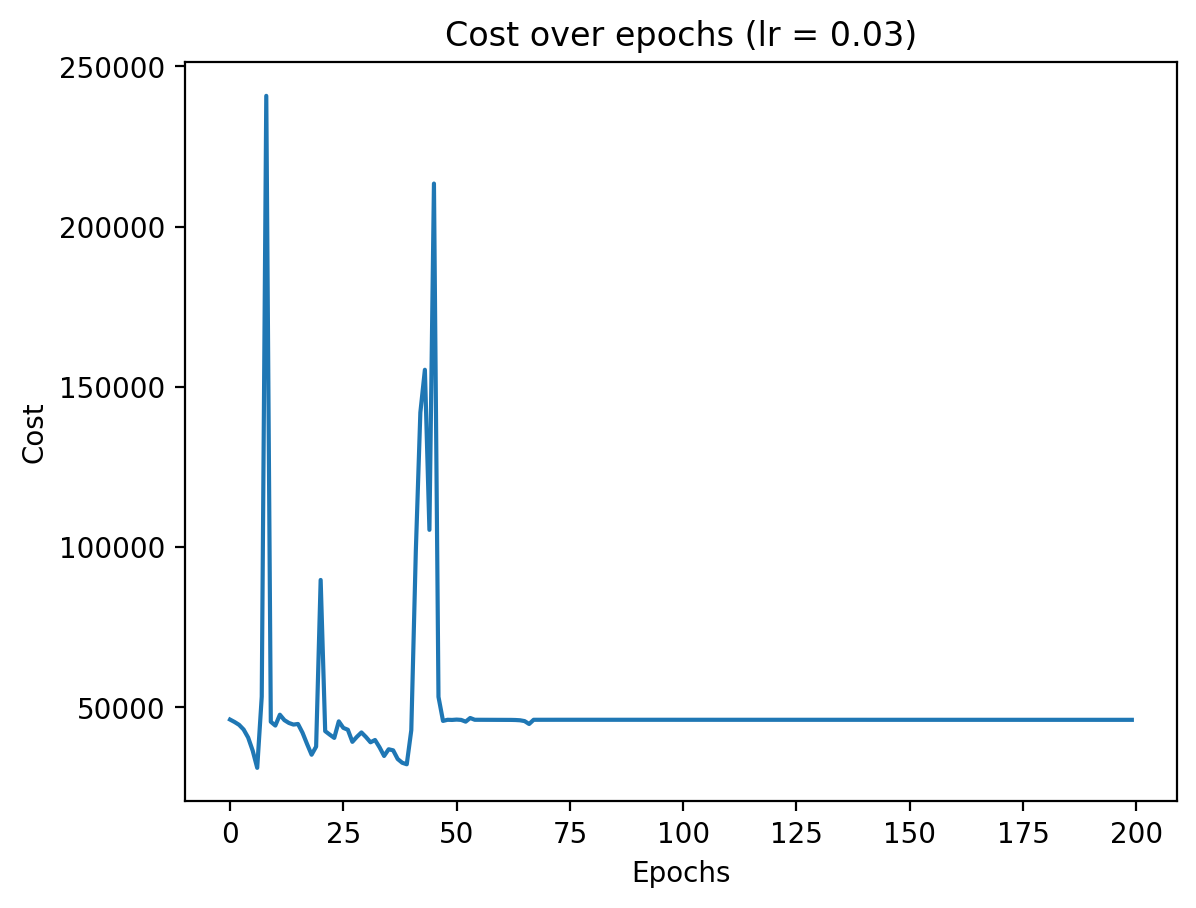

In [69]:
# Instantiate a NN with a 2-layer architecture (128 and 32 neurons)
PARAMS = [X_train, y_train, X_test, y_test, "relu", 10, [128, 32]]
nn_relu = NN(*PARAMS)
epochs_relu = 200
lr_relu = 0.03
nn_relu.fit(lr=lr_relu, epochs=epochs_relu)
nn_relu.plot_cost(lr_relu)